<a href="https://colab.research.google.com/github/aemrhb/Faster-Rcnn_Fine_Tuning/blob/main/faster_Rcnnn_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/faster-Rccn-finetune

/content/gdrive/My Drive/faster-Rccn-finetune


In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import YourCustomDataset
from torch.optim import SGD
import torch.utils.data
import torchvision.transforms as T

In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
import cv2
import os
from PIL import Image
import numpy as np
import torch
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

In [ ]:
# change this path based on your data
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos-00_0'

In [ ]:
# change the folder name if its required !
imge_path = os.path.join(files_dir, "img1" )
annots_path  = os.path.join(files_dir ,"annot_no_chiken")

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir,width, height, transforms=None):  # Add necessary arguments for dataset initialization
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = list(sorted(os.listdir(imge_path)))





    def __getitem__(self, idx):
        # Implement dataset item retrieval logic
        imge_path = os.path.join(self.files_dir , "img1" )
        img_name = self.imgs[idx]
        img_path = os.path.join(imge_path, img_name)
        img = cv2.imread(img_path)
        wt = img.shape[1]
        ht = img.shape[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0


        annots_path  = os.path.join(files_dir ,"annot_no_chiken")
        annot_file = img_name[:-4] + '.txt'
        annot_path = os.path.join(annots_path,annot_file)
        with open(annot_path, "r") as file:
          file_contents = file.read()
        lines = file_contents.split("\n")
        data = np.matrix(lines)
        boxes = []
        labels = []
        area = []
        width =[]
        height = []
        asepct = []

        for i in range(data.shape[1] - 1 ):
          boxe = []
          line = data[0,i].split(",")


          strr = line[2:6]

          res = [float(t) for t in strr]

          xmin_corr = (res[0]/wt)*self.width
          xmax_corr = (res[0]/wt)*self.width + (res[2]/wt)*self.width
          ymin_corr = (res[1]/ht)*self.height
          ymax_corr = (res[1]/ht)*self.height + (res[3]/ht)*self.height
          width.append((res[2]/wt)*self.width)
          height.append((res[3]/ht)*self.height)
          asepct.append(((res[3]/ht)*self.height)/((res[2]/wt)*self.width))

          are = int(res[2] * res[3])

          area.append(are)
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(float(line[7]))



        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])
        width = torch.as_tensor(width, dtype=torch.float32)
        height = torch.as_tensor(height, dtype=torch.float32)
        asepct = torch.as_tensor(asepct, dtype=torch.float32)


        target = {}

        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id
        target["width"] = width
        target["height"] = height
        target["asepct"] = asepct

        if self.transforms:

            sample = self.transforms(image = img_res)
                                    #  bboxes = target['boxes'],
                                    #  labels = labels)

            img_res = sample['image']
            # target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target


    def __len__(self):
        # Return the size of the dataset
        return len(self.imgs)


In [ ]:
from engine import evaluate
import utils
import transforms as T
def get_transform(train):
    if train:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])

In [ ]:
# thsi is just for tasting the calss data set is working , you can ignore it !

dataset = CustomDataset(files_dir, 224, 224)
# dataset[0]
# print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[87]
# for key, value in target.items():
#     print(key, value)
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 13.0935,  38.5062,  21.1768,  49.1742],
        [ 42.4987, 119.6876,  49.8452, 137.8440],
        [ 46.8633, 126.6098,  57.0028, 139.1756],
        [ 49.1015, 110.4973,  62.0760, 123.1907],
        [ 12.7470,  90.7293,  23.2540, 106.6240],
        [122.7380, 130.3058, 132.3315, 144.6884],
        [136.7993, 130.7320, 148.3073, 147.0249],
        [153.7533, 128.8840, 162.7430, 145.1551],
        [160.6308, 127.3098, 168.8978, 140.9053],
        [122.5910,  69.9876, 129.6190,  90.6267],
        [125.4330,  67.0071, 137.8125,  78.3004],
        [125.7568,  55.1040, 137.5465,  69.0729],
        [122.9095,  40.1644, 129.4073,  59.8391],
        [127.2022,  43.4373, 134.7762,  61.0991],
        [ 12.3865,  42.4107,  18.6060,  57.3627]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'area': tensor([1583, 2449, 2340, 3024, 3067, 2534, 3443, 2686, 2064, 2664, 2567, 3024,
        2348, 2457, 1708]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# from here to the 4 next cells we are providing some statistics for bounding boxes again you can ignore it for fine tuning!
dataset = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=True))
areas = []
width =[]
height = []
asepct = []
import itertools
for i in range(499)  :
  img, target = dataset[i]
  areas.append(target["area"].numpy())
  width.append((target["width"].numpy()))
  height.append((target["height"].numpy()))
  asepct.append((target["asepct"].numpy()))

list_area = [item for sublist in areas for item in sublist]
list_width = [item for sublist in width for item in sublist]
list_height = [item for sublist in height for item in sublist]
list_asepct = [item for sublist in asepct for item in sublist]

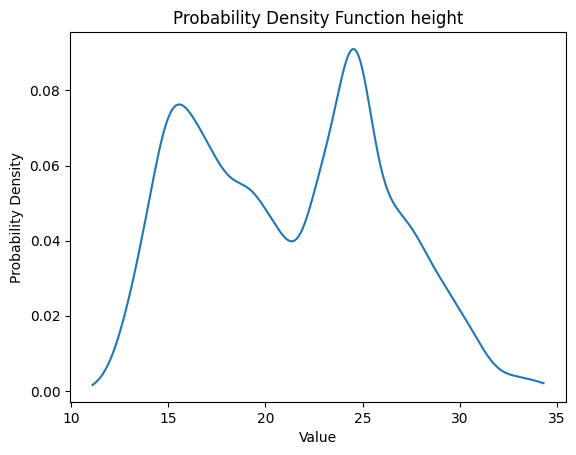

Mean: 21.2913
Median: 21.405
Standard Deviation: 4.980147


In [ ]:
# this just for providing some statistic for GT bounding boxes

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

data = list_width

# Create PDF
kde = stats.gaussian_kde(data)

# Generate x-axis values for PDF
x = np.arange(min(data), max(data), 0.1)  # Specify the step size, e.g., 0.1

# Compute statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)

# Plot PDF
plt.plot(x, kde(x))
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function height')
plt.show()

# Print statistics
print('Mean:', mean)
print('Median:', median)
print('Standard Deviation:', std_dev)

# Save the plot as an image file
# plt.savefig('plot_width.png')

# Save the statistics as a CSV file
statistics_df = pd.DataFrame({'Statistic': ['Mean', 'Median', 'Standard Deviation'],
                              'Value': [mean, median, std_dev]})
statistics_df.to_csv('statistics_width.csv', index=False)


In [ ]:
# here is the function that draws bounding boxes with different color

from PIL import Image, ImageDraw
def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    blue = (number*30 % 256)
    green = (number*103 % 256)
    red = (number*50 % 256)
    return (blue, green, red)

def plot_img_bbox(img, target):
    color_dict = {}
    # img = (img * 255).astype(np.uint8)
    # img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    # for box in (target['boxes']):
    for id, box in zip(target['labels'], target['boxes']):
      id  = id.item()
      if id in color_dict:
          color = color_dict[id]
      else:
          color_dict[id] = get_color(id)
          color = color_dict[id]


      bounding_box = (box[0], box[1],box[2],box[3])
      draw.rectangle(bounding_box, outline=color)
      text = f"ID: {id}"
      text_width, text_height = draw.textsize(text)
      text_position = (box[0], box[1] - text_height - 5)  # Adjust the vertical offset as needed
      draw.text(text_position, text, fill=color)


      # x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      # rect = patches.Rectangle((x, y),
      #                           width, height,
      #                           linewidth = 2,
      #                           edgecolor = '',
      #                           facecolor = 'none')

        # Draw the bounding box on top of the image

    img.show()



# plotting the image with bboxes. Feel free to change the index
# img, target = dataset[68]
# plot_img_bbox(img, target)

In [ ]:
# This is the function that provides the model (note: this function is the baseline and just you can change the number of classes here nothing more )
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
# This is the function that provides the model (note: this function change the anchor size and aspect ratio fill free to change it in the function if you need )

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import RPNHead

def get_object_detection_model(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Define the sizes and aspect ratios for the AnchorGenerator
    anchor_sizes = ( (8,), (16,), (32,),(64,) ,(128,),)
    aspect_ratios = tuple([( 0.5, 1.0, 2.0,3.0) for _ in range(len(anchor_sizes))])



    # Create a new AnchorGenerator with the desired sizes and aspect ratios
    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

    # # anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
    #                                aspect_ratios=((0.5, 1.0, 2.0),))

    # Set the AnchorGenerator in the RPN module of the model
    model.rpn.anchor_generator = anchor_generator

    # Get the in_channels from the model's backbone
    in_channels = model.backbone.out_channels

    # Update the box_coder in the RPNHead module to handle the new anchor sizes
    model.rpn.head = RPNHead(
        in_channels,
        anchor_generator.num_anchors_per_location()[0]
    )

    # Get the number of anchor boxes per location in the RPN module
    num_anchors = anchor_generator.num_anchors_per_location()[0]

    # Update the number of anchor boxes per location in the RPN module
    model.rpn.head.conv.num_anchors = num_anchors

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
# calling the data loader

dataset = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
# calling the model. and send it to GPU ( be careful which function you have ruined in previous cell )


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2


model = get_object_detection_model(num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 132MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Calling optimizer and learning rate schedule

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# change the function train one epoch to have loss function as well.

import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    losses_list = []

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        losses_list.append(loss_value)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return losses_list, metric_logger


Epoch: [0]  [ 0/40]  eta: 0:07:10  lr: 0.000133  loss: 3.2574 (3.2574)  loss_classifier: 0.6412 (0.6412)  loss_box_reg: 0.7401 (0.7401)  loss_objectness: 1.7812 (1.7812)  loss_rpn_box_reg: 0.0949 (0.0949)  time: 10.7528  data: 1.5661  max mem: 8221
Epoch: [0]  [10/40]  eta: 0:01:16  lr: 0.001414  loss: 1.7343 (2.1975)  loss_classifier: 0.5910 (0.5779)  loss_box_reg: 0.8473 (0.8487)  loss_objectness: 0.3290 (0.6962)  loss_rpn_box_reg: 0.0712 (0.0747)  time: 2.5492  data: 0.1903  max mem: 8382
Epoch: [0]  [20/40]  eta: 0:00:43  lr: 0.002695  loss: 1.4356 (1.7028)  loss_classifier: 0.4034 (0.4387)  loss_box_reg: 0.7701 (0.7953)  loss_objectness: 0.1032 (0.4069)  loss_rpn_box_reg: 0.0517 (0.0619)  time: 1.7325  data: 0.0528  max mem: 8382
Epoch: [0]  [30/40]  eta: 0:00:20  lr: 0.003975  loss: 0.9478 (1.4103)  loss_classifier: 0.2173 (0.3513)  loss_box_reg: 0.6617 (0.7206)  loss_objectness: 0.0422 (0.2847)  loss_rpn_box_reg: 0.0401 (0.0536)  time: 1.7515  data: 0.0525  max mem: 8382
Epoch: 

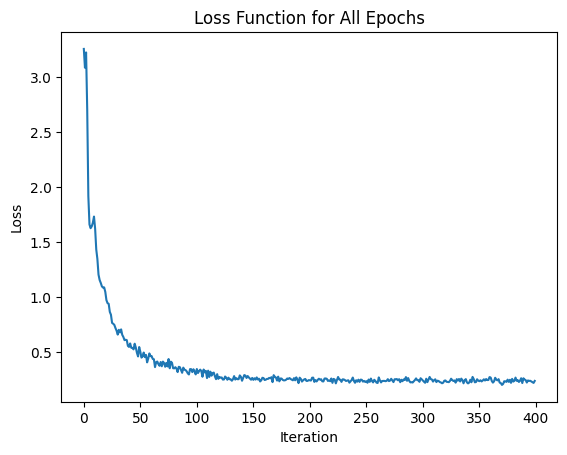

In [ ]:
# trainging loop
# only one class
num_epochs = 10
all_losses = []
for epoch in range(num_epochs):
  losses, metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  all_losses.extend(losses)
  evaluate(model, data_loader_test, device=device)
  # print(1,losses_reduced)
plt.plot(all_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Function for All Epochs')
plt.show()

In [ ]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')
    # return img.numpy()

EXPECTED OUTPUT


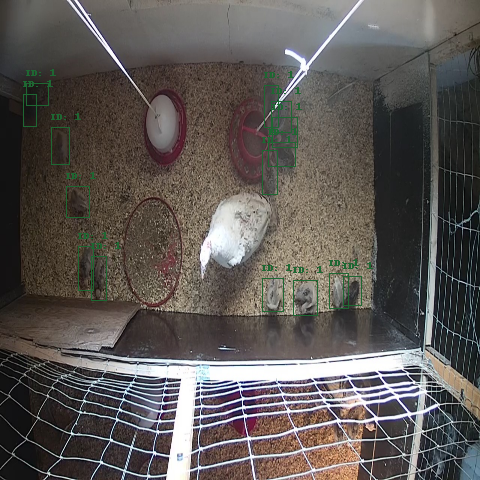

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


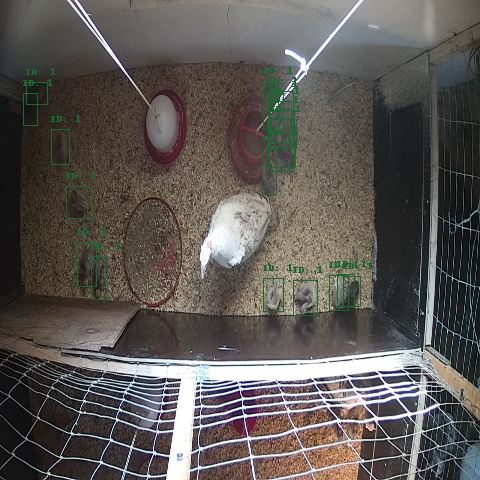

In [ ]:
prediction = {key: tensor.cpu() for key, tensor in prediction.items()}
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
# to save the model (note: changing the filename properly that indicates which variant is it )

torch.save(model.state_dict(), 'fine_tuned_model_3.pth')